# Workflow

In [1]:
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
import numpy as np
import pandas as pd

import mammos_analysis
import mammos_dft
import mammos_spindynamics
import mammos_mumag
import mammos_entity as me
import mammos_units as u

u.set_enabled_equivalencies(u.magnetic_flux_field());

In [2]:
%config InlineBackend.figure_format = "retina"

## 1: DFT data: magnetisation and anisotropy at zero Kelvin

In [3]:
results_dft = mammos_dft.db.get_micromagnetic_properties("Nd2Fe14B-136", print_info=True)

Found material in database.

Chemical Formula: Nd2Fe14B
Space group name: P42/mnm
Space group number: 136
Cell length a: 8.78 Angstrom
Cell length b: 8.78 Angstrom
Cell length c: 12.12 Angstrom
Cell angle alpha: 90.0 deg
Cell angle beta: 90.0 deg
Cell angle gamma: 90.0 deg
Cell volume: 933.42 Angstrom
ICSD_label: 
OQMD_label:

The first step loads spontaneous magnetisation $M_s$ and the uniaxial anisotropy constant $K_1$ from a database of DFT calculations.

In [4]:
results_dft

MicromagneticProperties(Ms_0=SpontaneousMagnetization(value=1280000.0, unit=A / m), K1_0=UniaxialAnisotropyConstant(value=4300000.0, unit=J / m3))

In [5]:
results_dft.Ms_0

SpontaneousMagnetization(value=1280000.0, unit=A / m)

In [6]:
results_dft.K1_0

UniaxialAnisotropyConstant(value=4300000.0, unit=J / m3)

## 2: Temperature-dependent magnetisation data from spindynamics database lookup

In [7]:
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetisation("Nd2Fe14B-136")

In the second step we use a spin dynamics calculation database. We load some points for the temperature-dependent magnetisation.

In [8]:
results_spindynamics.T

ThermodynamicTemperature(value=
[  0.          31.57894737  63.15789474  94.73684211 126.31578947
 157.89473684 189.47368421 221.05263158 252.63157895 284.21052632
 315.78947368 347.36842105 378.94736842 410.52631579 442.10526316
 473.68421053 505.26315789 536.84210526 568.42105263 600.
 630.         690.         720.         750.         780.        ],
 unit=K)

In [9]:
results_spindynamics.Ms

SpontaneousMagnetization(value=
[1460000.         1456985.36046193 1449449.93657199 1437972.77253639
 1422736.58364638 1403779.39648225 1381044.11152378 1354391.97626968
 1323600.99407897 1288353.67899904 1248213.31769096 1202584.11677895
 1150645.20320241 1091237.80552561 1022660.54963577  942263.95974459
  845538.33920183  723617.755767    553555.21471405  171781.14820705
       0.               0.               0.               0.
       0.        ],
 unit=A / m)

In [10]:
results_spindynamics.dataframe.head()

,T,Ms
0,0.000000,1.460000e+06
1,31.578947,1.456985e+06
2,63.157895,1.449450e+06
3,94.736842,1.437973e+06
4,126.315789,1.422737e+06


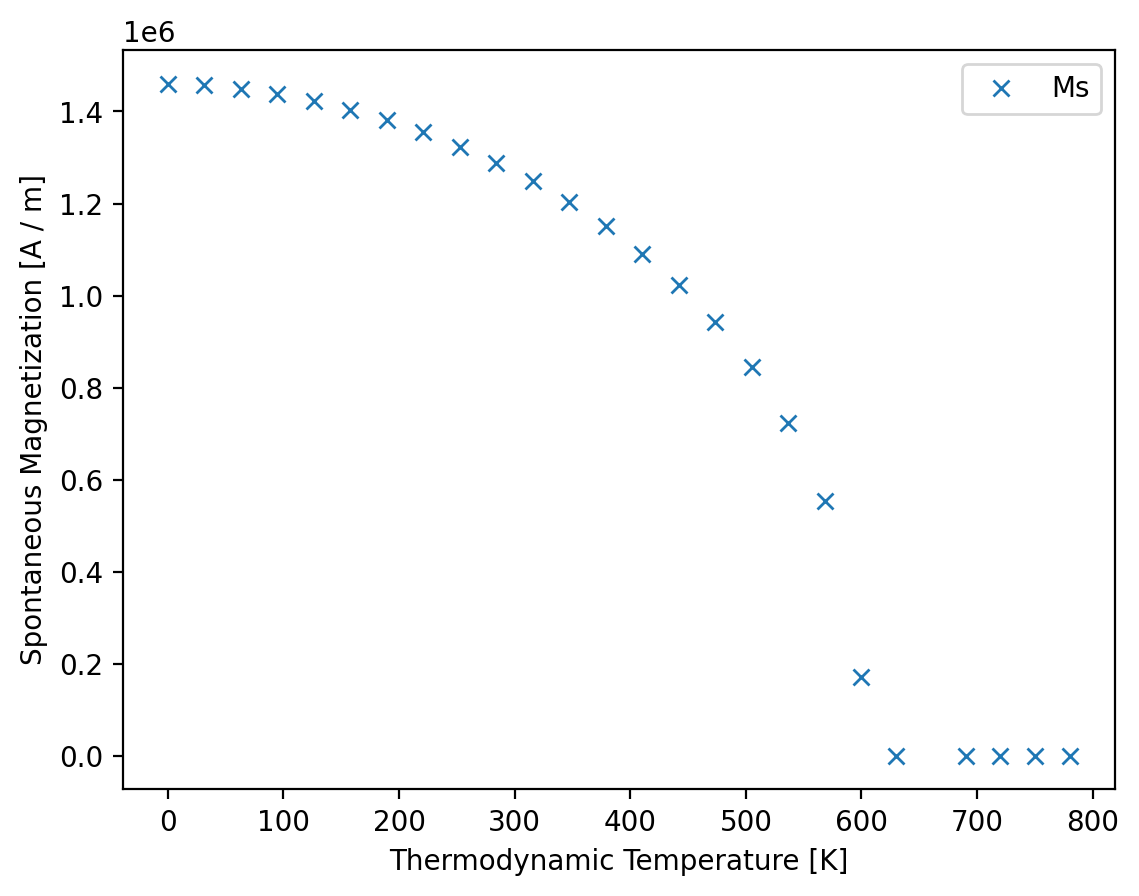

In [11]:
results_spindynamics.plot();

## 3: Calculate micromagnetic intrinsic properties using Kuz'min formula

In [12]:
kuzmin_result = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
    K1_0=results_dft.K1_0,
)

In [13]:
kuzmin_result

KuzminResult(Ms=Ms(T), A=A(T), K1=K1(T), Tc=ThermodynamicTemperature(value=587.7781199945, unit=K), s=<Quantity 0.96482643>)

In [14]:
kuzmin_result.Tc

ThermodynamicTemperature(value=587.7781199945, unit=K)

In [15]:
kuzmin_result.s  # in the docstring reference the paper

<Quantity 0.96482643>

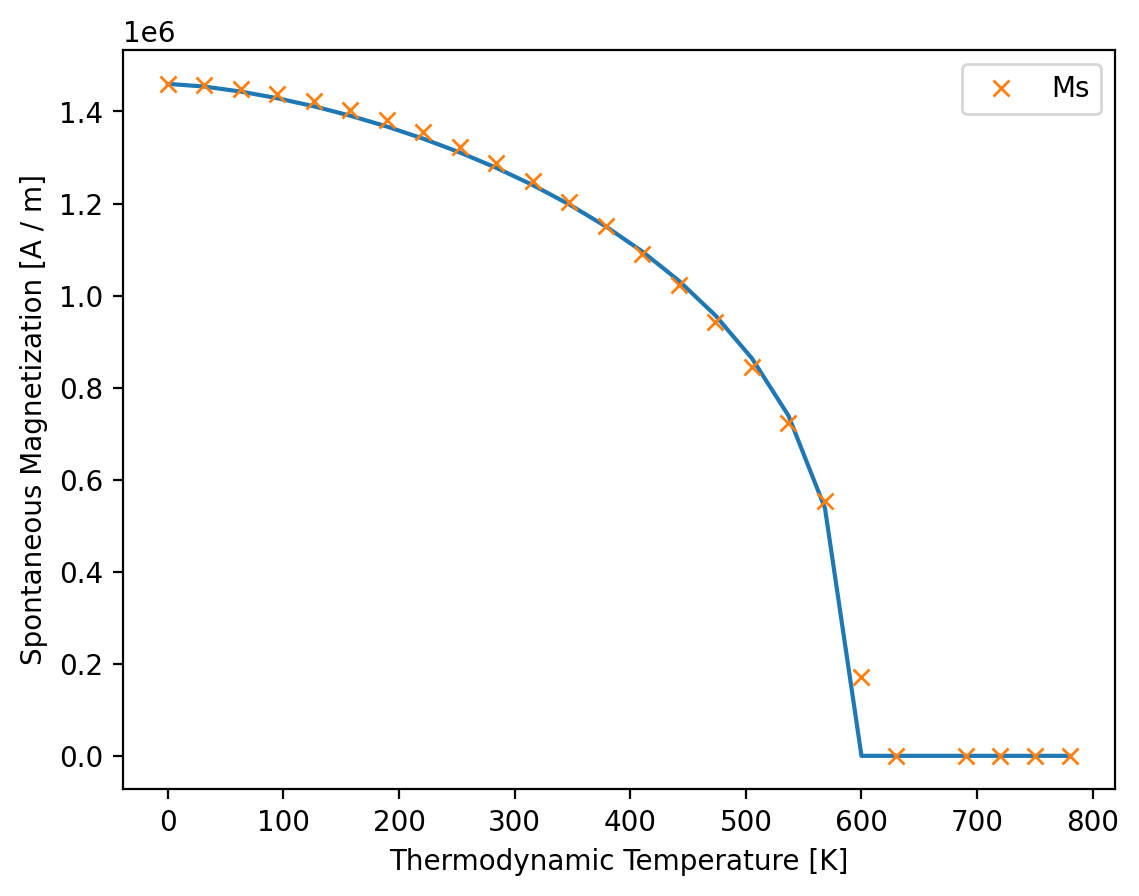

In [16]:
ax = kuzmin_result.Ms.plot()
results_spindynamics.plot(axes=ax);  # change kuzmin to not raise a warning for T>Tc

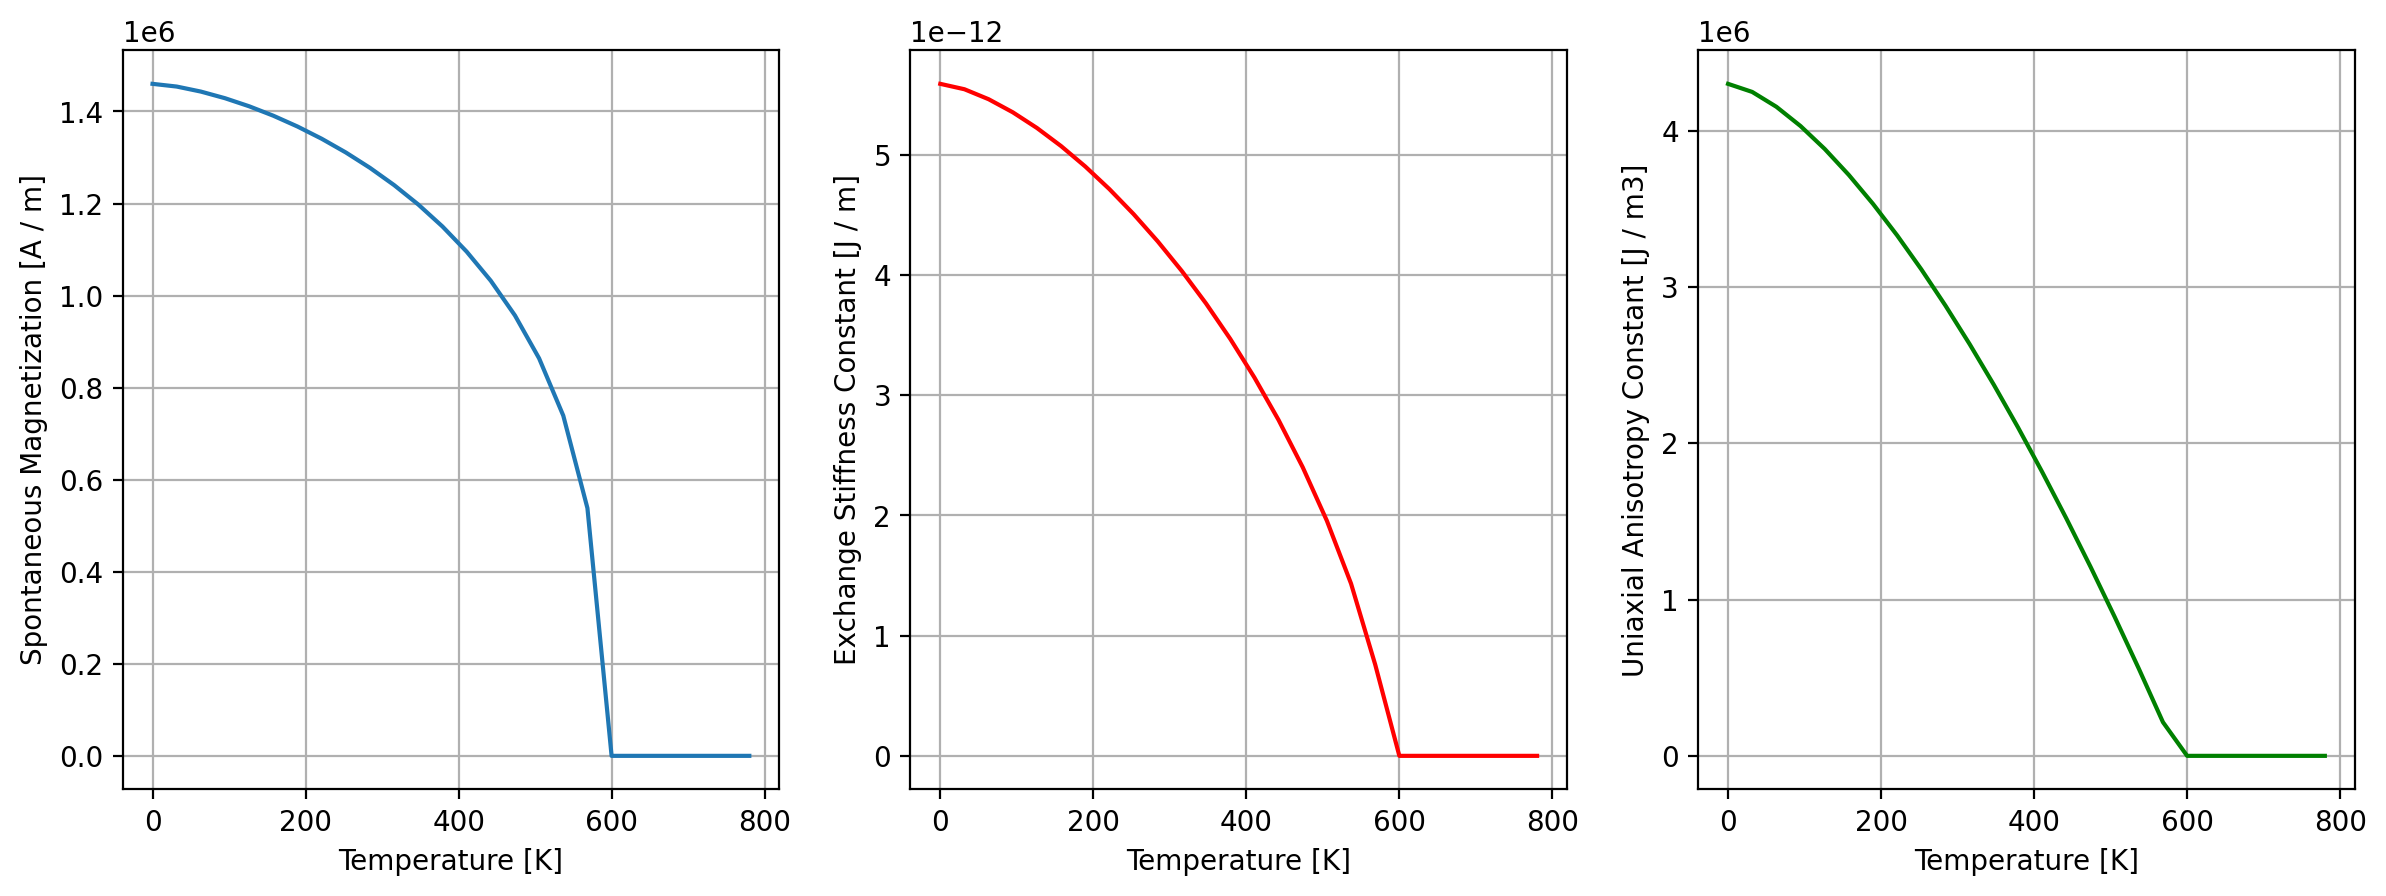

In [17]:
kuzmin_result.plot();  # range of the fit data T

In [18]:
temperature = me.Entity("ThermodynamicTemperature", value=300, unit="K")
temperature

ThermodynamicTemperature(value=300.0, unit=K)

In [19]:
kuzmin_result.Ms(temperature), kuzmin_result.A(temperature), kuzmin_result.K1(temperature) 

(SpontaneousMagnetization(value=1259264.6948938747, unit=A / m),
 ExchangeStiffnessConstant(value=4.158634560345106e-12, unit=J / m),
 UniaxialAnisotropyConstant(value=2759058.89344602, unit=J / m3))

## 4: Run micromagnetic simulation – Evaluate hysteresis loop

In [20]:
loop_results = mammos_mumag.hysteresis.run(
    mesh_filepath=mammos_mumag.mesh.CUBE_20_nm,
    Ms=kuzmin_result.Ms(temperature),
    A=kuzmin_result.A(temperature),
    K1=kuzmin_result.K1(temperature),
    hstart=(7*u.T).to(u.A / u.m),
    hfinal=(-10*u.T).to(u.A / u.m),
    hnsteps=30,
)

In [21]:
loop_results.H

ExternalMagneticField(value=
[ 5570423.00518393  5119484.00000238  4668544.99482082  4217605.98963926
  3766666.98445771  3315727.97927615  2864788.9740946   2413849.96891304
  1962910.96373148  1511971.95854993  1061032.95336837   610093.94818681
   159154.94300526  -291784.0621763   -742723.06735786 -1193662.07253941
 -1644601.07772097 -2095540.08290253 -2546479.08808408 -2997418.09326564],
 unit=A / m)

In [22]:
loop_results.M

SpontaneousMagnetization(value=
[ 1259072.54948708  1259052.82405831  1259029.88980012  1259003.00951291
  1258971.22082701  1258933.24832531  1258887.37253321  1258831.23005113
  1258761.49986537  1258673.39503963  1258559.80771452  1258409.80693537
  1258205.85570078  1257918.33169771  1257493.74506028  1256826.8856607
  1255684.14964104  1253440.55163891  1247685.52503743 -1258901.81208852],
 unit=A / m)

In [23]:
loop_results.energy_density

EnergyDensity(value=
[-11263295.79682548 -10549826.80367321  -9836369.86694098
  -9122927.00480457  -8409500.71360436  -7696094.11871252
  -6982711.1865229   -6269357.02861117  -5556038.34863297
  -4842764.11703658  -4129546.62228879  -3416403.17028152
  -2703358.95502994  -1990452.17392177  -1277743.76972834
   -565337.64884597    146572.15808256    857570.6657998
   1566526.87122736  -7192526.96371941],
 unit=J / m3)

The `dataframe` property generates a dataframe in the SI units.

In [24]:
loop_results.dataframe.head()

,configuration_type,H,M,energy_density
0,1,5.570423e+06,1.259073e+06,-1.126330e+07
1,1,5.119484e+06,1.259053e+06,-1.054983e+07
2,1,4.668545e+06,1.259030e+06,-9.836370e+06
3,1,4.217606e+06,1.259003e+06,-9.122927e+06
4,1,3.766667e+06,1.258971e+06,-8.409501e+06


We can generate a table in alternate units:

In [25]:
df = pd.DataFrame(
    {
        "mu0_H": loop_results.H.to(u.T),
        "J": loop_results.M.to(u.T),
    },
)
df.head()

,mu0_H,J
0,7.000000,1.582197
1,6.433333,1.582172
2,5.866667,1.582144
3,5.300000,1.582110
4,4.733333,1.582070


In [26]:
# INFO: useful information
si_df = (df * u.T.to("A/m"))
si_df.columns = ['H', 'M']
si_df.head()

,H,M
0,5.570423e+06,1.259073e+06
1,5.119484e+06,1.259053e+06
2,4.668545e+06,1.259030e+06
3,4.217606e+06,1.259003e+06
4,3.766667e+06,1.258971e+06


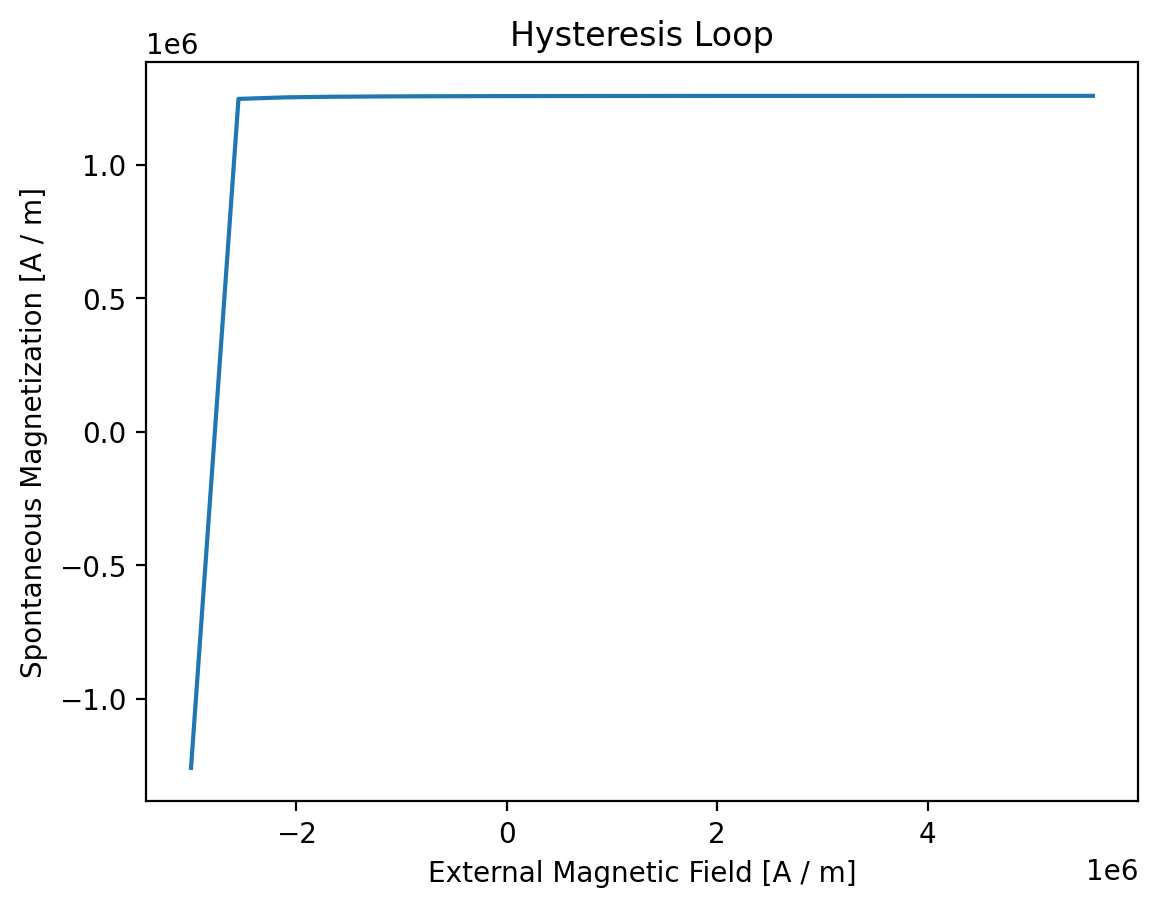

In [27]:
loop_results.plot(duplicate=False);

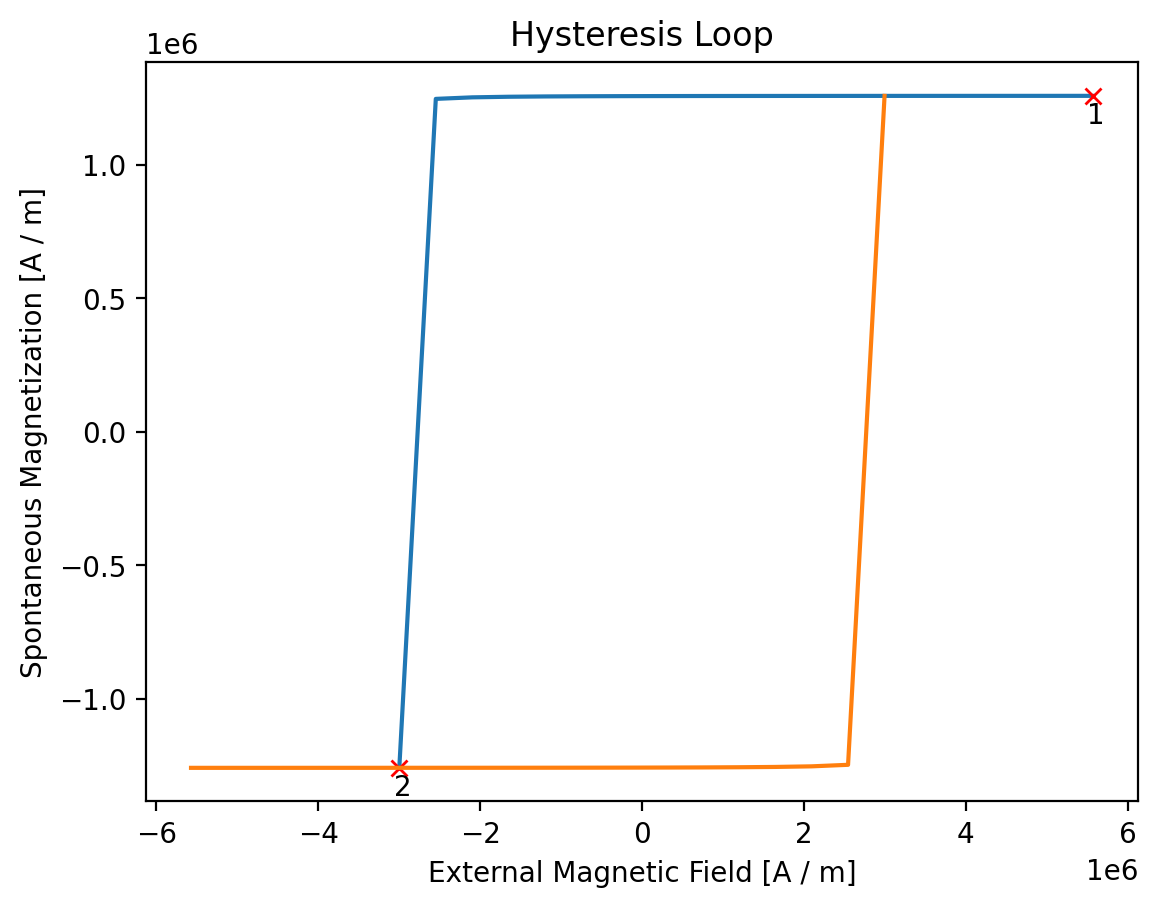

In [28]:
loop_results.plot(duplicate=True, configuration_marks=True);

In [29]:
loop_results.configurations

{1: PosixPath('/home/swapneel/Projects/mammos-repos/mammos/docs/source/examples/workflows/hystloop/hystloop_0001.vtu'),
 2: PosixPath('/home/swapneel/Projects/mammos-repos/mammos/docs/source/examples/workflows/hystloop/hystloop_0002.vtu')}

In [30]:
loop_results.plot_configuration(1, jupyter_backend="trame")

Widget(value='<iframe src="http://localhost:44193/index.html?ui=P_0x7f4895e71d50_0&reconnect=auto" class="pyvi…

We can extract the extrinsic properties with the `extrinsic_properties` function from the `mammos_analysis` package:

In [31]:
extrinsic_properties = mammos_analysis.hysteresis.extrinsic_properties(
    loop_results.M,
    loop_results.H,
    demagnetisation_coefficient=None,
)

In [32]:
# extrinsic_properties.Hc

In [33]:
# extrinsic_properties.Mr

In [34]:
# extrinsic_properties.BHmax
# is Not A Number (not yet implemented).

In [35]:
Mr = mammos_analysis.hysteresis.extract_remanent_magnetization(loop_results.H, loop_results.M)
Mr

Remanence(value=1258104.376640873, unit=A / m)

In [36]:
Hc = mammos_analysis.hysteresis.extract_coercive_field(loop_results.H, loop_results.M)
Hc

CoercivityHcExternal(value=2770939.676832175, unit=A / m)

In [37]:
mammos_analysis.hysteresis.extract_coercive_field(loop_results.H.quantity, loop_results.M.quantity)

CoercivityHcExternal(value=2770939.676832175, unit=A / m)

In [38]:
mammos_analysis.hysteresis.extract_coercive_field(loop_results.H.value, loop_results.M.value)

CoercivityHcExternal(value=2770939.676832175, unit=A / m)

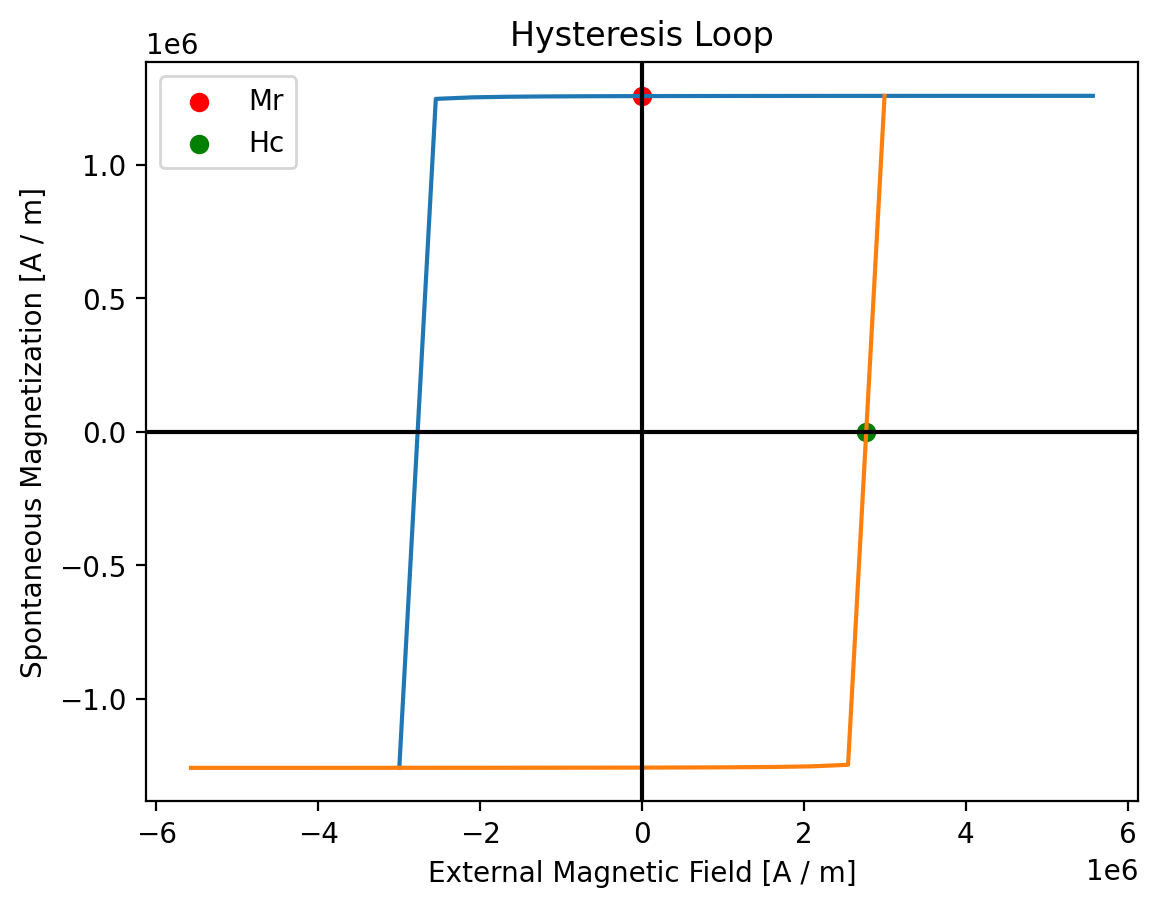

In [39]:
loop_results.plot()
plt.axhline(0, c="k")
plt.axvline(0, c="k")
plt.scatter(0, Mr.value, c="r", label="Mr")
plt.scatter(Hc.value, 0, c="g", label="Hc")
plt.legend();

In [40]:
T = np.linspace(0, 600, 4)

simulations = []
for temperature in T:
    loop_results = mammos_mumag.hysteresis.run(
        mesh_filepath=mammos_mumag.mesh.CUBE_20_nm,
        Ms=kuzmin_result.Ms(temperature),
        A=kuzmin_result.A(temperature),
        K1=kuzmin_result.K1(temperature),
        hstart=(7*u.T).to(u.A / u.m),
        hfinal=(-10*u.T).to(u.A / u.m),
        hnsteps=30,
    )
    simulations.append(loop_results)

In [41]:
Hcs = [
    mammos_analysis.hysteresis.extract_coercive_field(H=res.H, M=res.M).value
    for res in simulations
]

In [42]:
pd.DataFrame({'T': T, 'Hc': Hcs})

,T,Hc
0,0.0,3.672942e+06
1,200.0,3.221909e+06
2,400.0,2.319455e+06
3,600.0,5.570423e+06


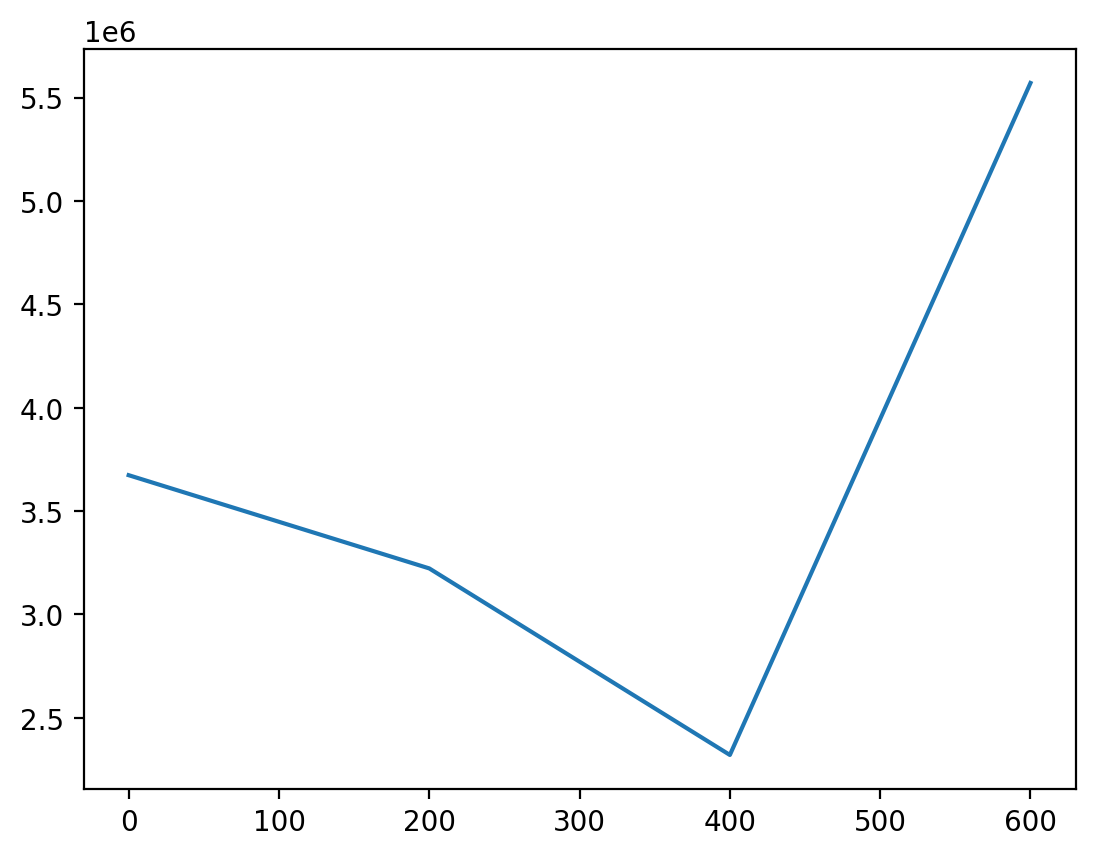

In [43]:
plt.plot(T, Hcs)

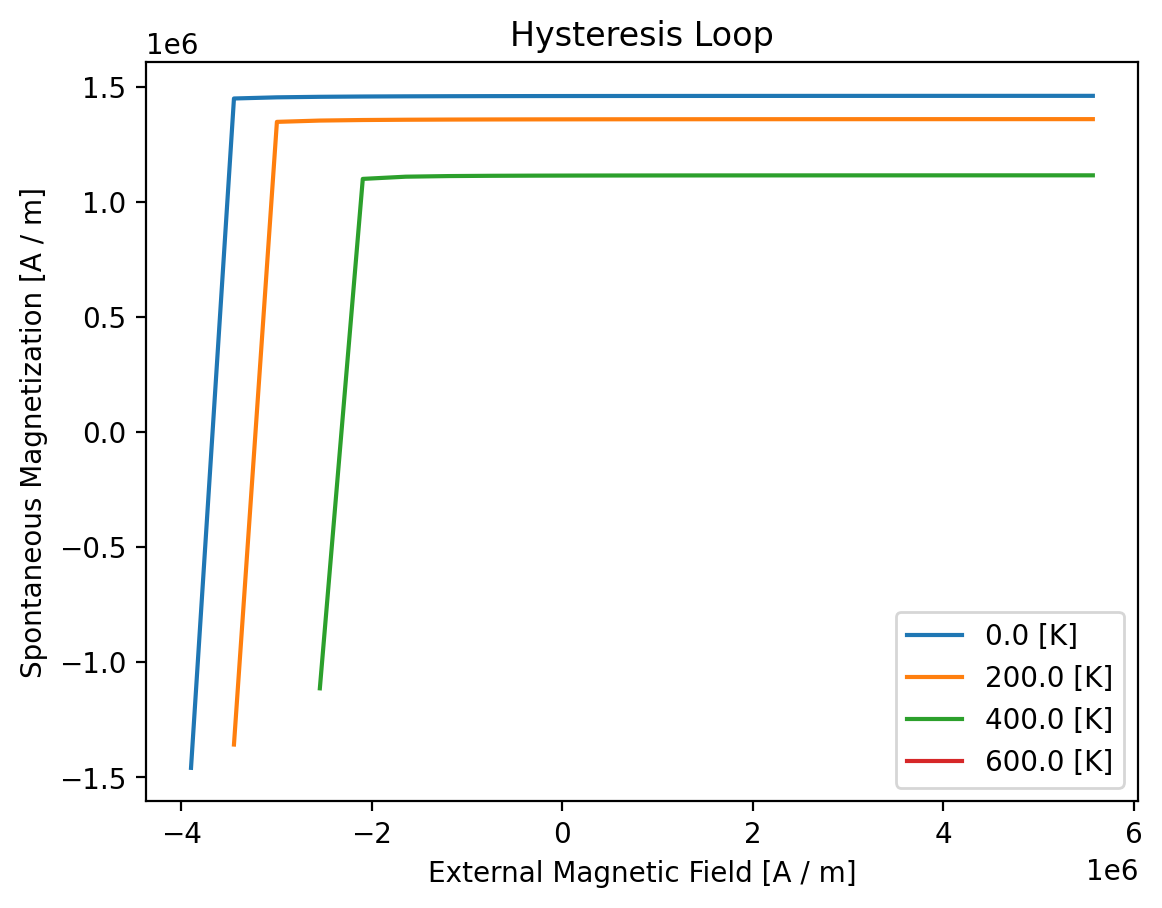

In [44]:
fix, ax = plt.subplots()
for temperature, sim in zip(T, simulations):
    sim.plot(duplicate=False, axes=ax, label=f"{temperature} [K]")